# Kaggle House Prices — EDA 與前處理一步到位

使用方式：
1. 將本 Notebook 放在和 `train.csv`、`test.csv` 同一個資料夾。
2. 依序執行每個區塊（Shift+Enter）。
3. 產出圖會在 `figs/`，中介資料在 `artifacts/`。

你可以把圖直接放進 PPT，把 `artifacts/train_clean.csv` 交給隊友建模。

## Step 0：匯入套件與建立輸出資料夾（figs/、artifacts/）
### 作用:
1. 載入會用到的 pandas / numpy / matplotlib。
2. 建兩個資料夾：放圖（figs/）和中介檔（artifacts/）。

In [1]:
# Step 0: Imports & folders
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

os.makedirs("figs", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

print("工作目錄:", os.getcwd())

工作目錄: C:\Users\brady\OneDrive\桌面\大三上\機器學習\final project


## Step 1：讀檔與快速檢查
### 作用:
1. 讀進 Kaggle 的 train.csv、test.csv。
2. 新增 SalePrice_log = log1p(SalePrice)，後續線性模型會用。
3. 輸出前幾列到 artifacts/_peek_train_head.csv 方便檢查。

In [2]:
# Step 1: Load data & quick peek
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

train["SalePrice_log"] = np.log1p(train["SalePrice"])  # 之後線性模型會用
print("train shape:", train.shape, " test shape:", test.shape)
train.head().to_csv("artifacts/_peek_train_head.csv", index=False)

train shape: (1460, 82)  test shape: (1459, 80)


## Step 2：目標分布（原始 & log1p）
### 作用:
1. 看房價 SalePrice 是否右偏。
2. 對數化（log1p）後通常更接近常態，線性模型更穩。

Saved figs/01 & 02


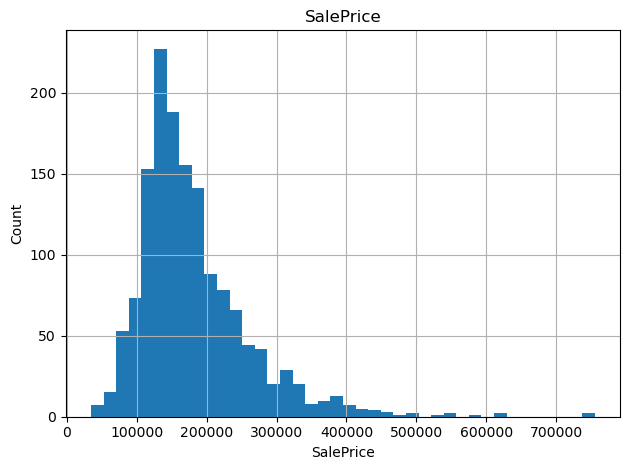

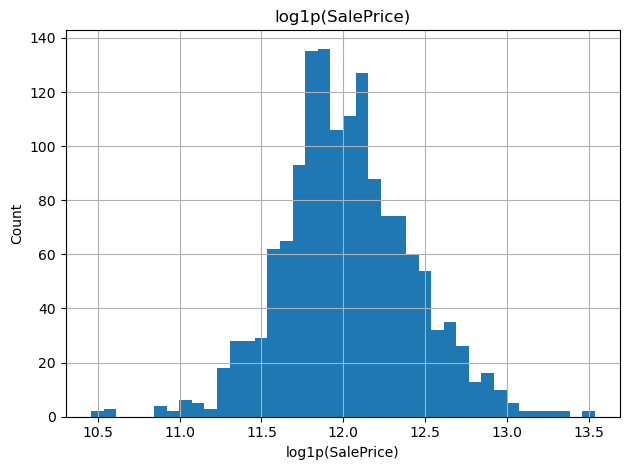

In [3]:
# Step 2: Target distribution (SalePrice / log1p)
plt.figure(); train["SalePrice"].hist(bins=40)
plt.title("SalePrice"); plt.xlabel("SalePrice"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("figs/01_saleprice_hist.png", dpi=200)

plt.figure(); train["SalePrice_log"].hist(bins=40)
plt.title("log1p(SalePrice)"); plt.xlabel("log1p(SalePrice)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("figs/02_saleprice_log_hist.png", dpi=200)
print("Saved figs/01 & 02")

## Step 3：缺值統計（Top-20）
### 作用:
1. 找出最常缺的欄位，之後針對性補值。
2. 圖：缺值最多的前 20 個欄位長條圖。
3. 表：所有欄位缺值數輸出到 artifacts/_na_counts_train.csv。

Saved figs/03 and artifacts/_na_counts_train.csv


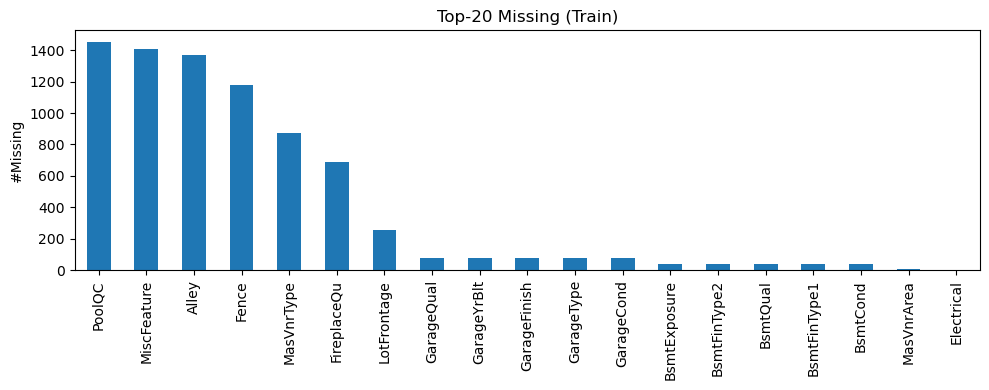

In [4]:
# Step 3: Missing values Top-20
na_count = train.isna().sum().sort_values(ascending=False)
na_top20 = na_count[na_count>0].head(20)

plt.figure(figsize=(10,4))
na_top20.plot(kind="bar")
plt.title("Top-20 Missing (Train)"); plt.ylabel("#Missing")
plt.tight_layout(); plt.savefig("figs/03_missing_top20.png", dpi=220)
na_count.to_csv("artifacts/_na_counts_train.csv")
print("Saved figs/03 and artifacts/_na_counts_train.csv")

## Step 4：類別欄位出現次數（Top-30）與類別多寡
### 作用:
1. 看每個類別欄位的「最常出現的值」數量，了解分布偏不偏。
2. 也輸出每個類別欄位的「類別數」（n_unique）供後續 One-Hot 估計欄位膨脹。

Saved figs/04 and artifacts/_cat_unique_counts.csv


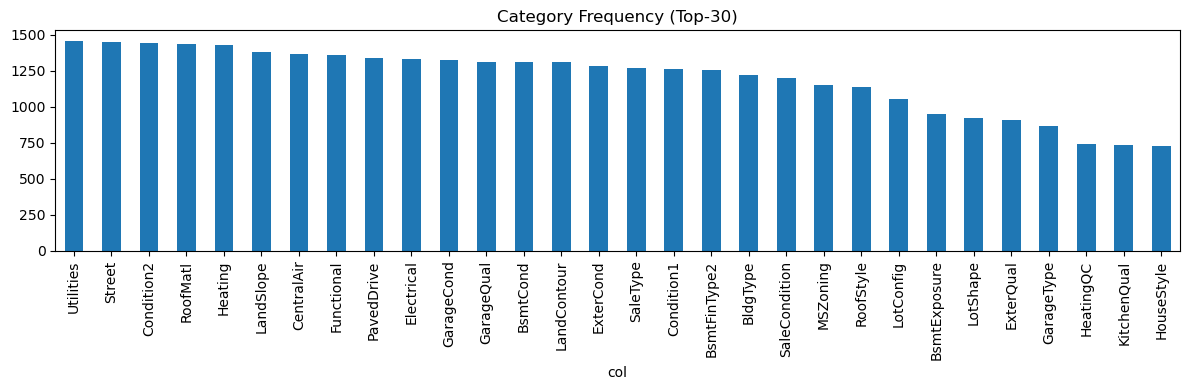

In [5]:
# Step 4: Category frequencies (Top-30)
cat_cols = [c for c in train.columns if train[c].dtype=="object"]
top = []
for c in cat_cols:
    top.append((c, train[c].value_counts().head(1).iloc[0]))
top_df = pd.DataFrame(top, columns=["col","top_value_count"])\
         .sort_values("top_value_count", ascending=False)

plt.figure(figsize=(12,4))
top_df.head(30).set_index("col")["top_value_count"].plot(kind="bar")
plt.title("Category Frequency (Top-30)"); plt.tight_layout()
plt.savefig("figs/04_cat_topfreq30.png", dpi=220)

pd.DataFrame({"col":cat_cols, "n_unique":[train[c].nunique() for c in cat_cols]})\
  .sort_values("n_unique", ascending=False).to_csv("artifacts/_cat_unique_counts.csv", index=False)
print("Saved figs/04 and artifacts/_cat_unique_counts.csv")

## Step 5：數值相關性（與 SalePrice 的 Top-20 & 熱力圖）
### 作用:
1. 用皮爾森相關（Pearson r）衡量「線性」關係強度。
2. 先看「與 SalePrice 的相關係數絕對值 Top-20」，再畫所有數值欄位的熱力圖。

Saved figs/30 & 31


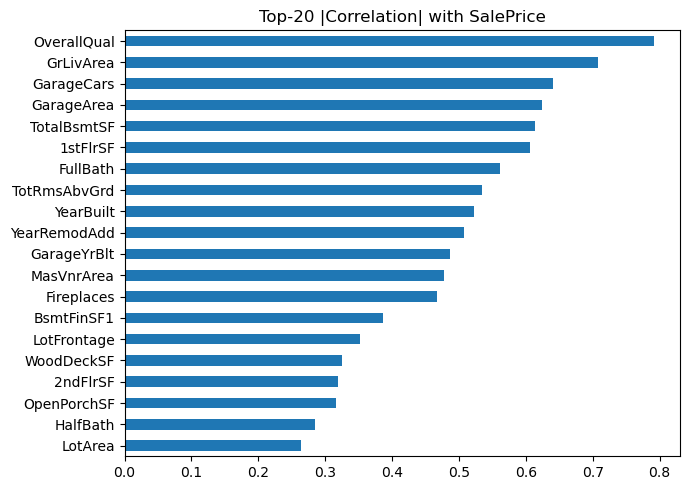

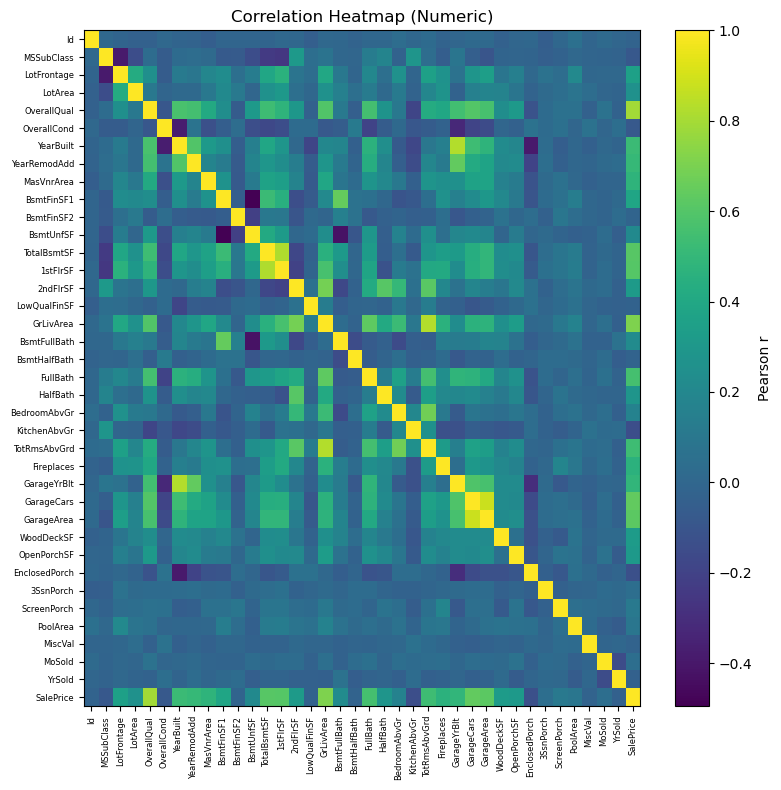

In [6]:
# Step 5: Numeric correlation (heatmap & Top-20 with SalePrice)
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["SalePrice_log"]]
corr = train[num_cols].corr(numeric_only=True)
sp = corr["SalePrice"].drop("SalePrice").abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(7,5))
sp.sort_values().plot(kind="barh")
plt.title("Top-20 |Correlation| with SalePrice")
plt.tight_layout(); plt.savefig("figs/30_corr_top20.png", dpi=220)

plt.figure(figsize=(8,8))
plt.imshow(corr.values, aspect='auto'); plt.colorbar(label="Pearson r")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)
plt.title("Correlation Heatmap (Numeric)")
plt.tight_layout(); plt.savefig("figs/31_corr_heatmap.png", dpi=280)
print("Saved figs/30 & 31")

## Step 6：關鍵連續特徵 vs 價格（含 log 版）
### 作用:
1. 用散點圖直觀檢查幾個面積/坪數類特徵與價格的關係。
2. 同時畫出「對數後」版本，通常更接近線性。

Saved figs/10_* scatter plots


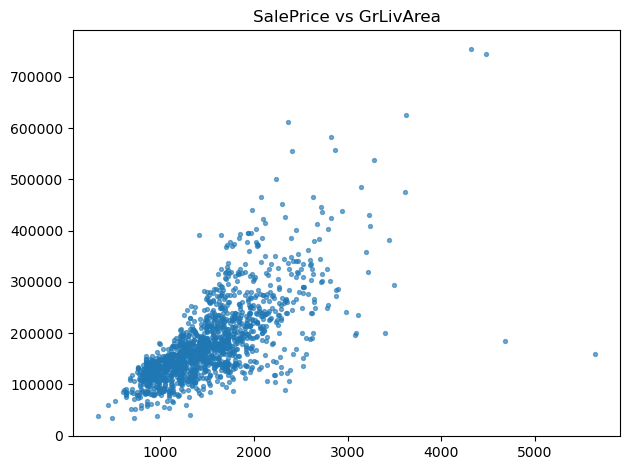

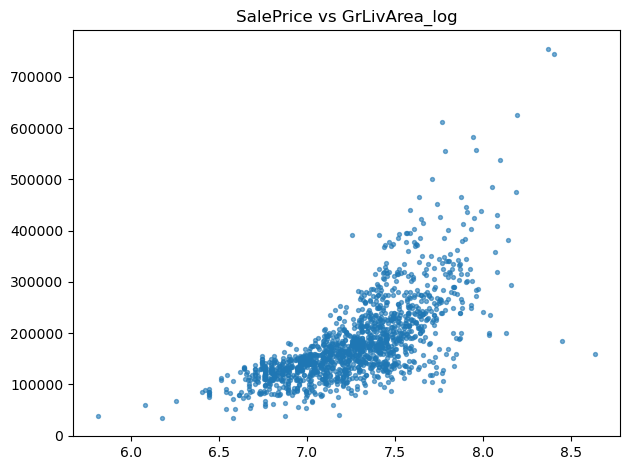

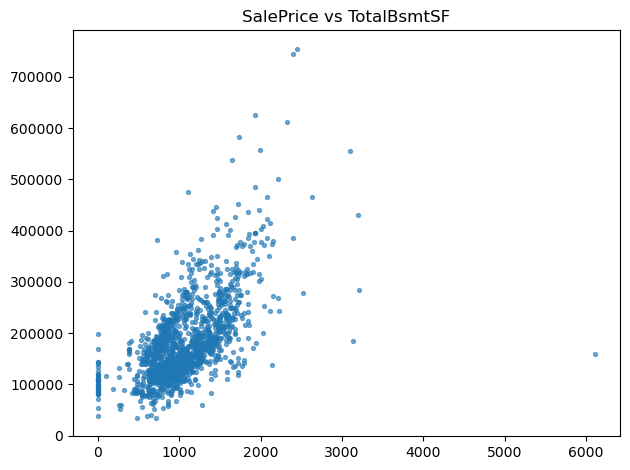

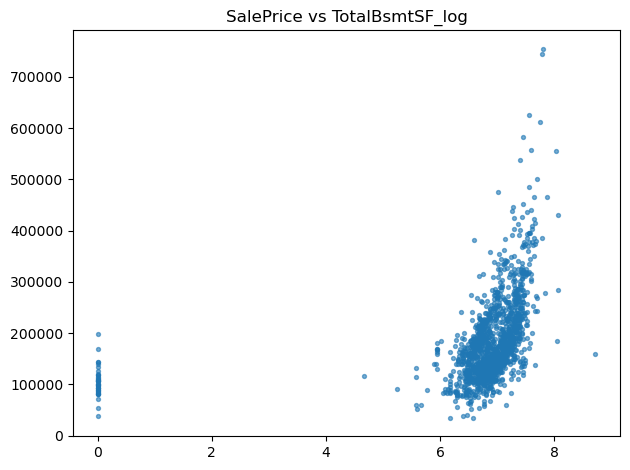

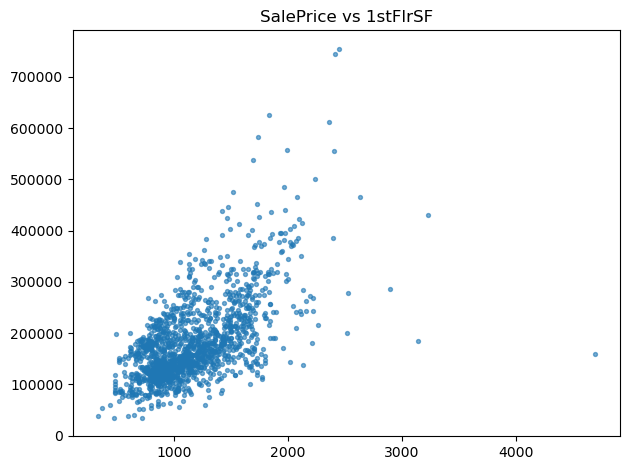

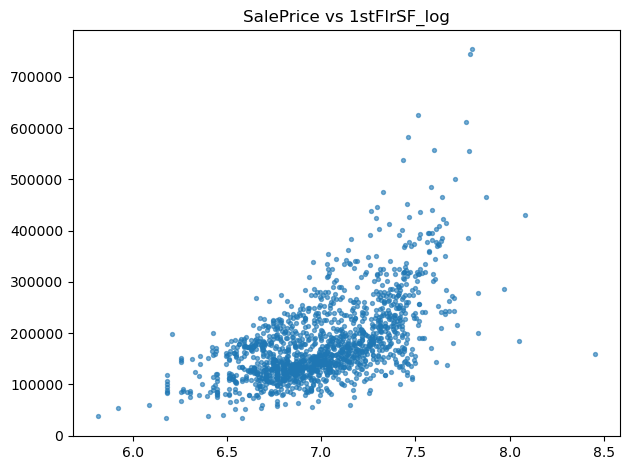

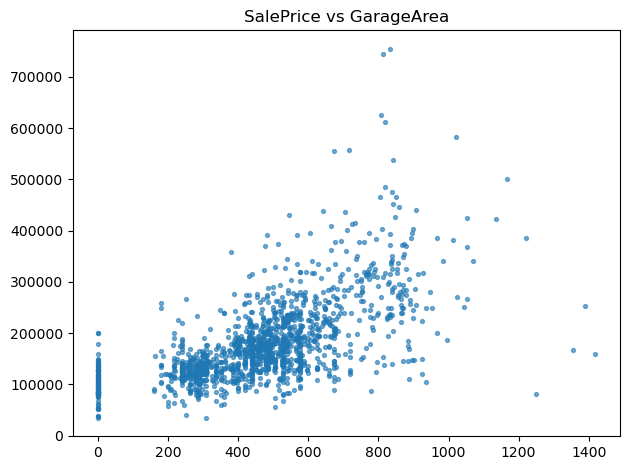

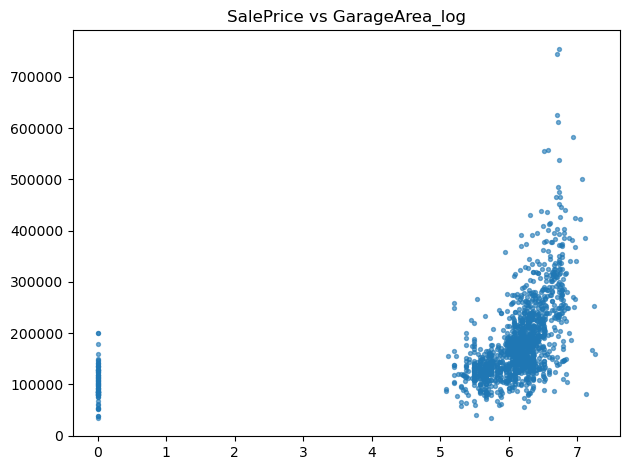

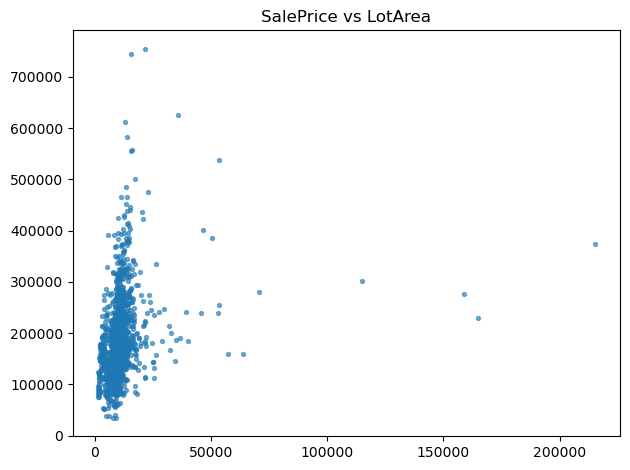

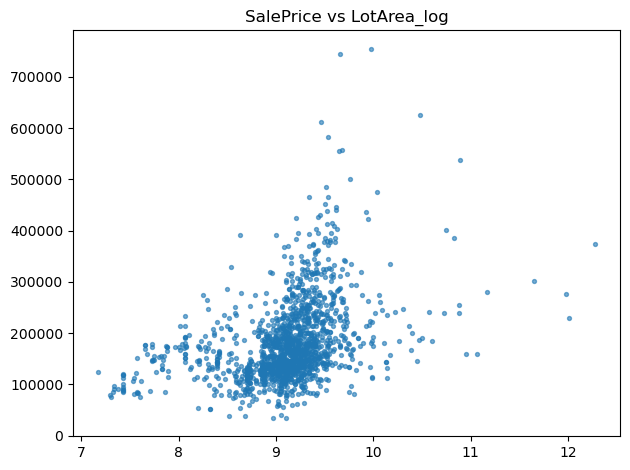

In [7]:
# Step 6: Key scatter relationships (+ log versions)
def scatter(x):
    if x in train.columns:
        plt.figure(); plt.scatter(train[x], train["SalePrice"], s=8, alpha=0.6)
        plt.title(f"SalePrice vs {x}")
        plt.tight_layout(); plt.savefig(f"figs/10_scatter_{x}.png", dpi=200)

for col in ["GrLivArea","TotalBsmtSF","1stFlrSF","GarageArea","LotArea"]:
    scatter(col)
    if col in train.columns:
        train[col+"_log"] = np.log1p(train[col])
        scatter(col+"_log")
print("Saved figs/10_* scatter plots")

## Step 7：分組圖（OverallQual、Neighborhood）
### 作用:
1. 類別/等級特徵對價格的群組差異。
2. OverallQual（整體品質）通常等級越高，中位價越高。
3. Neighborhood（社區）之間的中位價差異也很明顯。

Saved figs/20 & 21 (if columns exist)


<Figure size 800x400 with 0 Axes>

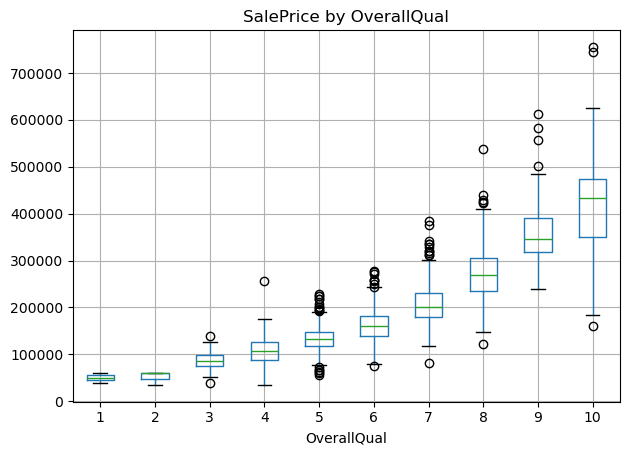

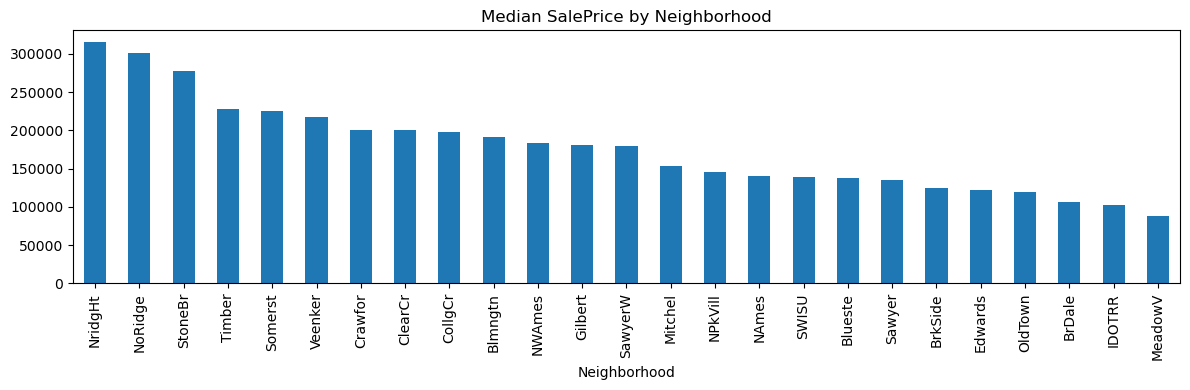

In [8]:
# Step 7: Grouped plots — OverallQual & Neighborhood
if "OverallQual" in train:
    plt.figure(figsize=(8,4))
    train.boxplot(column="SalePrice", by="OverallQual")
    plt.title("SalePrice by OverallQual"); plt.suptitle("")
    plt.tight_layout(); plt.savefig("figs/20_box_by_overallqual.png", dpi=220)

if "Neighborhood" in train:
    med_nb = train.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False)
    plt.figure(figsize=(12,4))
    med_nb.plot(kind="bar")
    plt.title("Median SalePrice by Neighborhood")
    plt.tight_layout(); plt.savefig("figs/21_median_by_neighborhood.png", dpi=240)
print("Saved figs/20 & 21 (if columns exist)")

## Step 8：最小化清理與衍生特徵，輸出乾淨版資料
### 作用:
1. 依 Kaggle 常規把缺值分成三類補法：
(1)「沒有此設施」→ 填 "None"（如車庫型態、巷弄、地下室曝光…）
(2)面積/數量類 → 填 0
(3)一般類別 → 用「眾數」補
2. LotFrontage 用同社區中位數補，兜底用全域中位數。
3. 建立常用衍生特徵：TotalSF、TotalBath、AgeAtSale、RemodAge。
4. 輸出 artifacts/train_clean.csv、artifacts/test_clean.csv 之後能建模。

In [9]:
# Step 8: Feature engineering (clean minimal) + save artifacts
train_clean = train.copy(); test_clean = test.copy()

# None-fill for 'no such amenity'
for df in (train_clean, test_clean):
    for c in ["Alley","BsmtExposure","BsmtFinType1","BsmtFinType2","GarageType","GarageFinish","Fence","MiscFeature"]:
        if c in df: df[c] = df[c].fillna("None")

# Zero-fill for areas/counts
for df in (train_clean, test_clean):
    for c in ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","GarageYrBlt","GarageCars",
              "GarageArea","MasVnrArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
              "3SsnPorch","ScreenPorch","PoolArea","MiscVal","LowQualFinSF"]:
        if c in df: df[c] = df[c].fillna(0)

# Mode-fill for general categoricals
for df in (train_clean, test_clean):
    for c in ["MSZoning","Electrical","KitchenQual","Exterior1st","Exterior2nd","SaleType","Functional","Utilities"]:
        if c in df: df[c] = df[c].fillna(df[c].mode()[0])

# LotFrontage by Neighborhood median
if {"LotFrontage","Neighborhood"}.issubset(train_clean.columns):
    med = train_clean.groupby("Neighborhood")["LotFrontage"].median()
    train_clean["LotFrontage"] = train_clean.apply(lambda r: med[r["Neighborhood"]] if pd.isna(r["LotFrontage"]) else r["LotFrontage"], axis=1)
    test_clean["LotFrontage"]  = test_clean.apply(lambda r: med.get(r["Neighborhood"], np.nan) if pd.isna(r["LotFrontage"]) else r["LotFrontage"], axis=1)
    train_clean["LotFrontage"] = train_clean["LotFrontage"].fillna(train_clean["LotFrontage"].median())
    test_clean["LotFrontage"]  = test_clean["LotFrontage"].fillna(train_clean["LotFrontage"].median())

# Derived features
for df in (train_clean, test_clean):
    df["TotalSF"] = df.get("TotalBsmtSF",0) + df.get("1stFlrSF",0) + df.get("2ndFlrSF",0)
    df["TotalBath"] = df.get("FullBath",0) + 0.5*df.get("HalfBath",0) + df.get("BsmtFullBath",0) + 0.5*df.get("BsmtHalfBath",0)
    if {"YrSold","YearBuilt"}.issubset(df.columns):
        df["AgeAtSale"] = df["YrSold"] - df["YearBuilt"]
    if {"YrSold","YearRemodAdd"}.issubset(df.columns):
        df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]

train_clean.to_csv("artifacts/train_clean.csv", index=False)
test_clean.to_csv("artifacts/test_clean.csv", index=False)
print("Saved artifacts/train_clean.csv & artifacts/test_clean.csv")

Saved artifacts/train_clean.csv & artifacts/test_clean.csv


## Step 9：離群值旗標（Outliers flags）
### 作用:
1. 以 99.5 百分位作為「極端大」的簡單門檻，產生旗標。
2. 目前只標記不刪除；之後訓練時你或隊友可選擇：封頂、忽略、或用魯棒模型。

In [10]:
# Step 9: Outliers flags (for reporting)
def mark_outlier(s, q=0.995):
    return s > s.quantile(q)

out = {
    "GrLivArea_out": mark_outlier(train["GrLivArea"]) if "GrLivArea" in train else False,
    "LotArea_out":   mark_outlier(train["LotArea"])   if "LotArea" in train else False,
}
pd.DataFrame(out).to_csv("artifacts/outliers_flags.csv", index=False)
print("Saved artifacts/outliers_flags.csv")

Saved artifacts/outliers_flags.csv


## 總結
1. Step 0–1：載入資料、建立 SalePrice_log、確認檔案正常。
2. Step 2–7（EDA）：用直方圖、缺值圖、散點、分組圖、相關圖了解資料結構與重要特徵。
3. Step 8（特徵工程入門版）：完成一致的缺值處理規則＋幾個高性價比衍生特徵，輸出乾淨版 CSV。
4. Step 9：標記離群值，留待訓練階段決策如何處理。
### artifacts/train_clean.csv 之後能直接做 線性回歸 / Ridge / Lasso / GBDT 等模型並做可解釋性分析（PermImp/SHAP/PDP）